In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import math
from scipy import stats
from sklearn import linear_model
from src.utils.analysis_movies_function import extract_us_nonus, get_all_genre,  get_movies_genre_change, plot_movies_genre_change, plot_percentage_movies_genre_all, linear_regression_plot, plot_per_continent,continent_data, create_world_map
from src.utils.analysis_plots_function import count_key_words, plot_key_words_occ, percentage_key_words_before_after, plot_key_words_occ_zoomed


# Loading the data

All the raw data preprocessing, and basic analysis can be found in the jupyter notebook `src/utils/preprocessing.ipynb`. 
In the preprocessing, we did several things: 
- We removed outliers from the dataset (example: a movie with several years of runtime...)
- We transformed data in a more useful way (example: string date to datetime, dict to list...)
- We added new columns from the existing ones and infered some values based on the majority of the data 
- We matched the cleaned ethnicity ID with another dataset to get meaningful ethnicities 

The raw datasets are in `/src/data` and the cleaned and formated datasets are then saved as pkl files in `/data`

In [2]:
movies = pd.read_pickle('data/movies.pkl')
tvtropes = pd.read_pickle('data/tvtropes.pkl')
plot_summaries = pd.read_pickle('data/plot_summaries.pkl')

### US selection

In [3]:
us_movies,nonus_movies = extract_us_nonus(movies)
genres_unique = get_all_genre(movies)

# 9/11 US

The genres with the highest change are social issues, horror, political cinema

In [4]:
df = get_movies_genre_change(us_movies, genres_unique, -1 , 1940,  1945,1950)

In [5]:
print(df.count_before.describe())
print("median")
print(df.count_before.median())

count    358.000000
mean       0.279330
std        1.126293
min        0.000000
25%        0.000000
50%        0.000000
75%        0.053348
max       13.176847
Name: count_before, dtype: float64
median
0.0


In [6]:
print(df.count_after.describe())
print("median")
print(df.count_after.median())

count    358.000000
mean       0.279260
std        1.123180
min        0.000000
25%        0.000000
50%        0.000000
75%        0.050063
max       11.889862
Name: count_after, dtype: float64
median
0.0


We notice here that the distribution of genres is right skewed, with a maximum percentage lower than 10% and a median around 0.03%. We should keep this in mind when we will the percentage and the focus should be more on the change than the absolute value

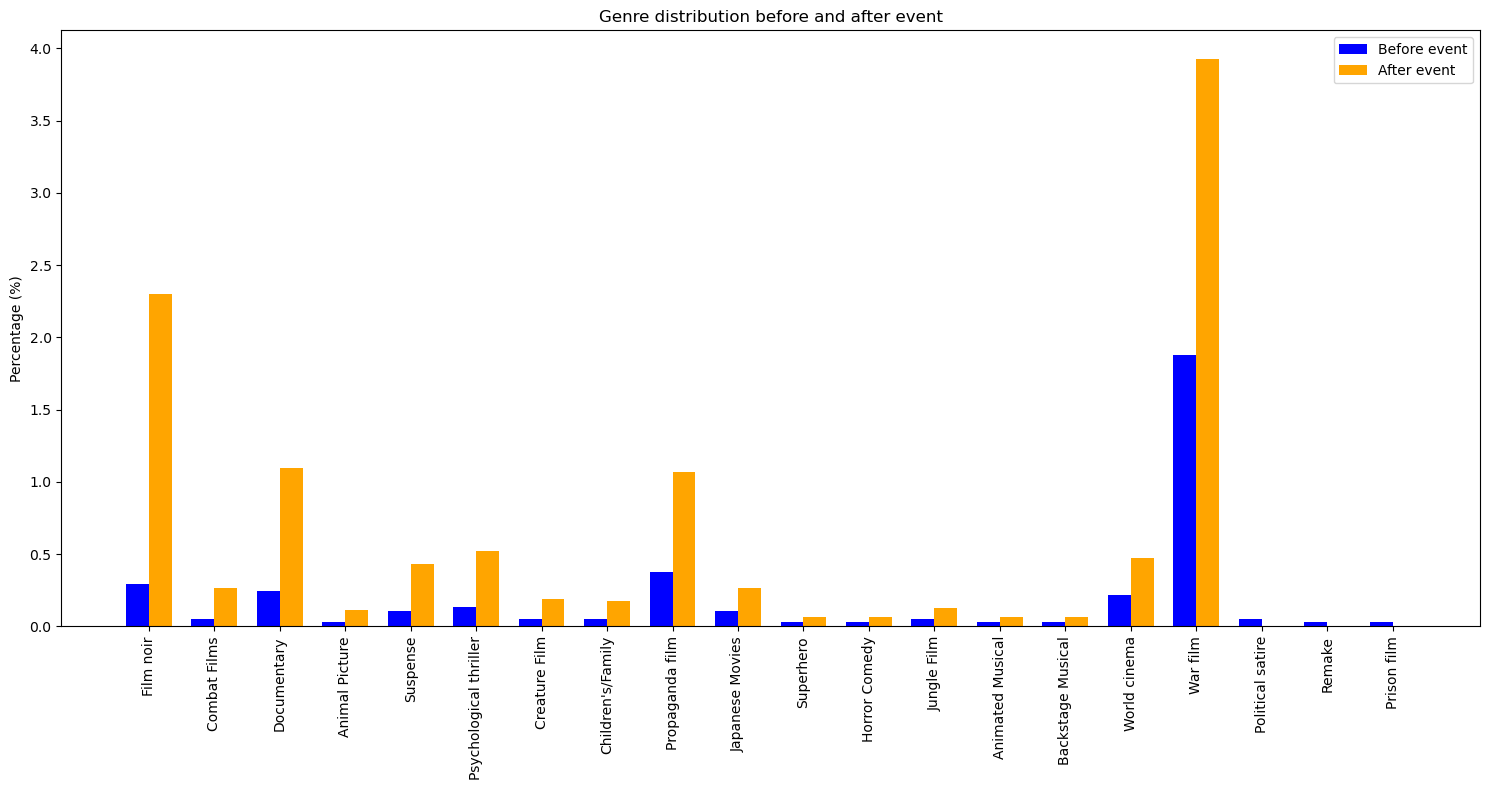

t-statistic: -1.5770577208923913
p-value: 0.12307189423725653


In [7]:
#to get the genre the most impacted, we will choose a small time range to limit cofounding factors
df = get_movies_genre_change(movies, genres_unique, 20, 1937,  1941,1948)
plot_movies_genre_change(df)
t_statistic, p_value = stats.ttest_ind(df.count_before, df.count_after)

print("t-statistic:", t_statistic)
print("p-value:", p_value)

for the 20 genres the most changing, there is a significant difference 

In [8]:
# from these 20 genres we focus on the ones linked to politics and social 
genres = ['Propaganda film', 'Combat Films', 'Suspense', 'Documentary', 'Psychological thriller', 'History','War film', 'Film noir']

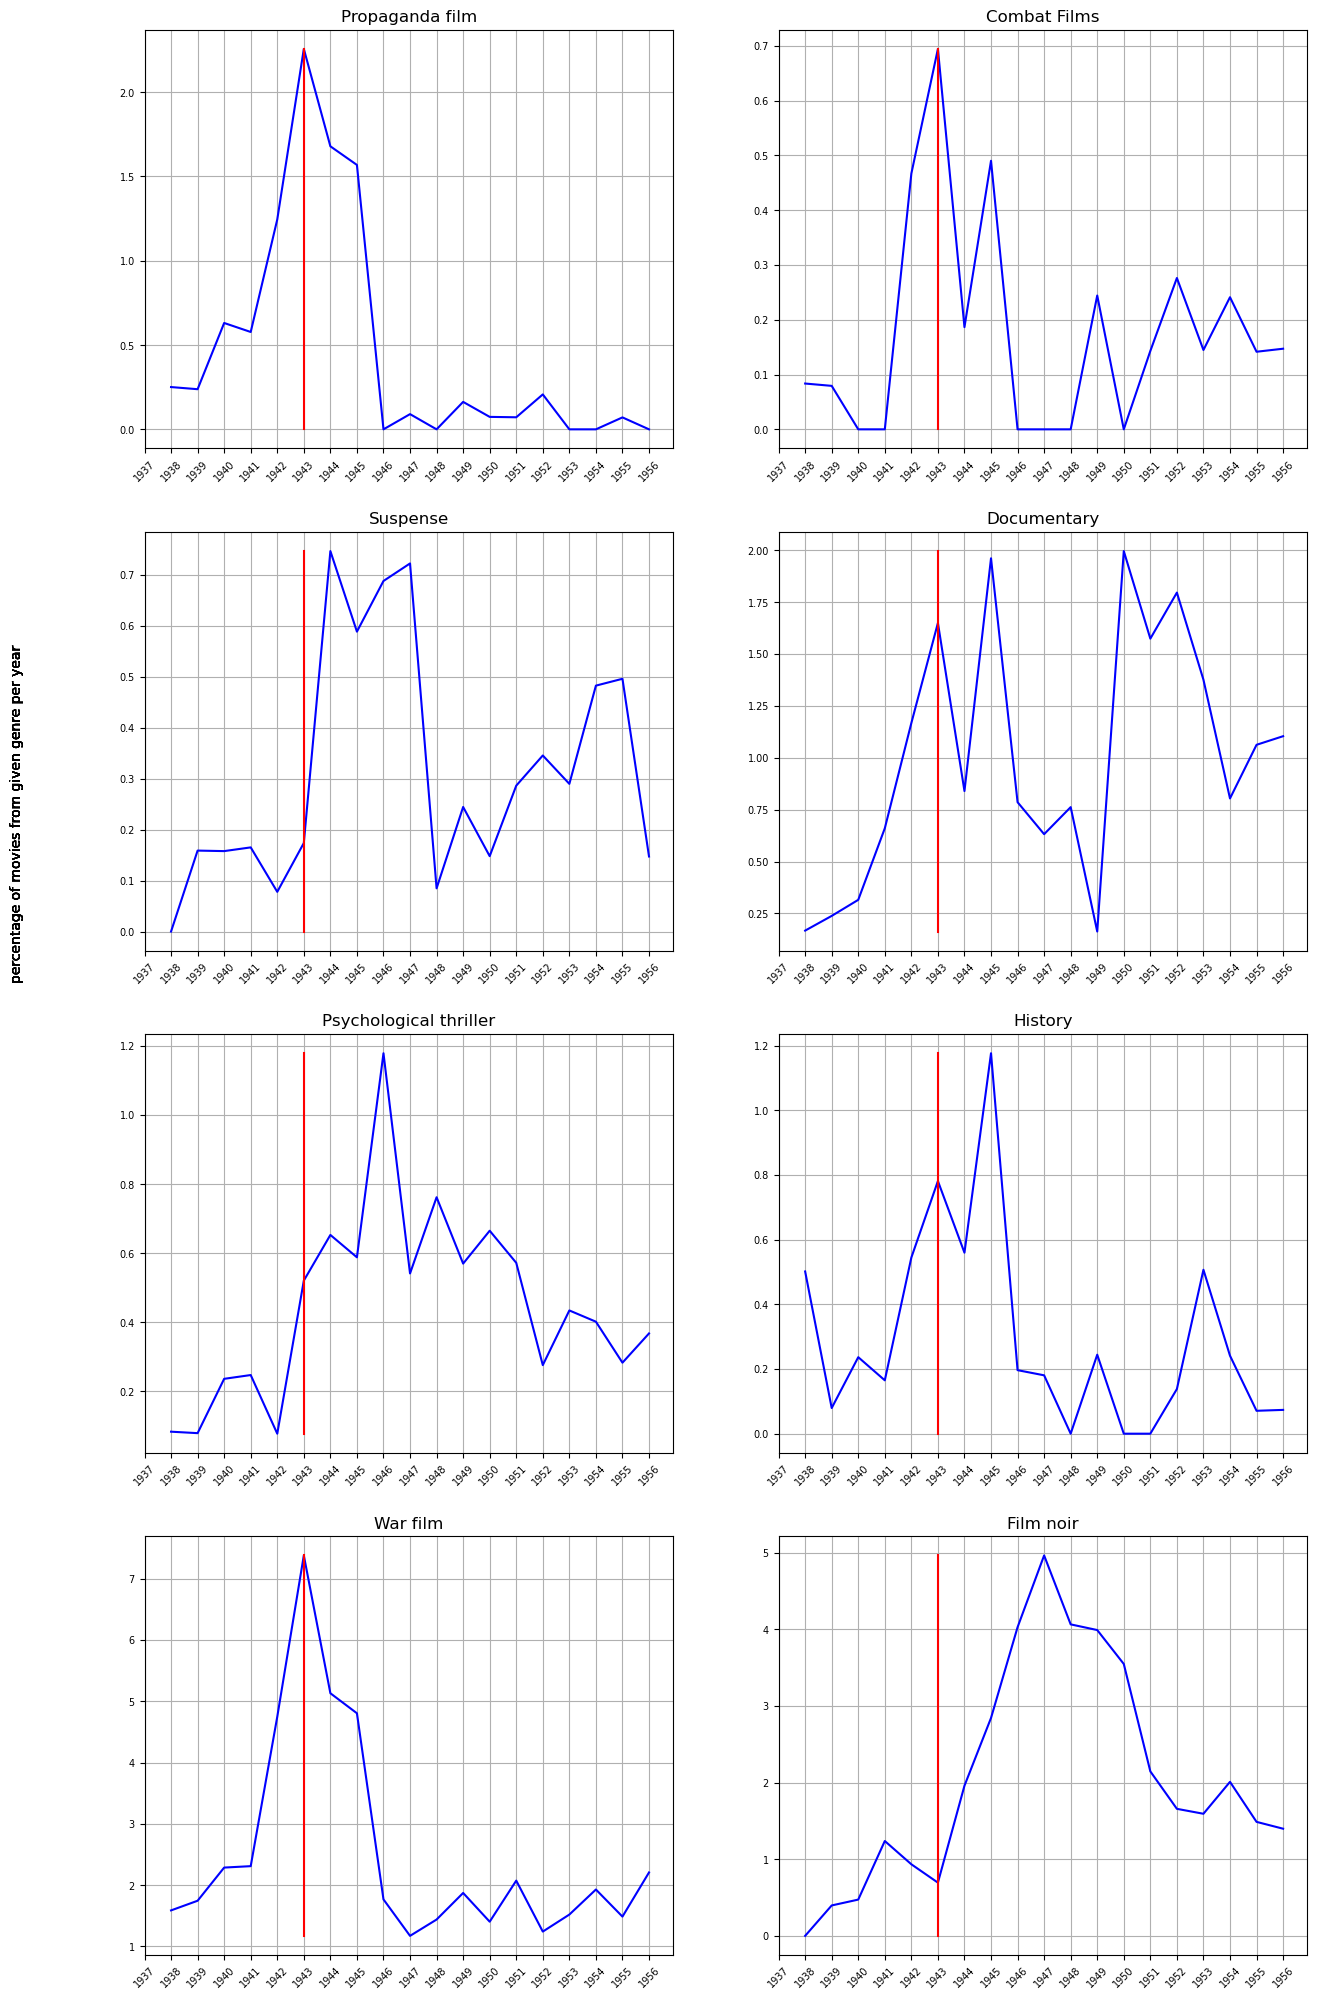

In [9]:
df = get_movies_genre_change(movies, genres_unique, 20, 1937,  1941,1948)
#genres =['Social issues','Road-Horror','Political cinema','Political satire', 'Law & Crime','Illnesses & Disabilities','Holiday Film','Social problem film','Glamorized Spy Film','Swashbuckler films','Dystopia', 'Documentary']
plot_percentage_movies_genre_all(movies,genres,1937, 1957, 1943,4,2)

We notice an upward trend in the social issues genre after 2002. A similar pattern appears in political cinema, where the trend shifts from a decrease to an increase. Additionally, the road horror genre shows a peak after 2002

### split rest of the worlds into continents

In [10]:
genres = ['War film', 'Combat Films', 'Propaganda film', 'History']  
create_world_map(movies, 1930, 1950, 1940, genres)


# TREND BEFORE 

In [11]:
def count_genre(data, genre):
    '''
    function that countes the occurence of a given genre in the data 
    '''
    total = 0
    for j in data["Movie_genres"]:
        if j is not None:
            total += j.count(genre)
    return total

def get_all_genre(data):
    genres_unique = []
    for j in data["Movie_genres"]:
        if j is not None:
            for genre in j:
                genres_unique.append(genre)
    genres_unique = np.unique(genres_unique)
    return genres_unique

def linear_regression_plot(data,year_initial,year_end,focus_year,genre):


    movies_year = data.groupby(data.Movie_release_date.dt.year).apply(lambda x: count_genre(x, genre)).reset_index()
    movies_year.columns = ["year", "count"]

    # get the total number of genre for a given year, a movies with 5 genres will add 5 to the total count  
    #if we want to divise by the total number of movies, change by sum by count 
    yearly_movies = data.groupby(data.Movie_release_date.dt.year)['nb_genre'].agg('sum')

    #percentage of a given genre
    percentage = movies_year.loc[(movies_year.year>year_initial) & (movies_year.year<year_end)]["count"]/yearly_movies[(yearly_movies.index >year_initial) & (yearly_movies.index < year_end)].values*100
    percentage_before = movies_year.loc[(movies_year.year>year_initial) & (movies_year.year<=focus_year)]["count"]/yearly_movies[(yearly_movies.index >year_initial) & (yearly_movies.index <= focus_year)].values*100
    percentage_after = movies_year.loc[(movies_year.year>=focus_year) & (movies_year.year<year_end)]["count"]/yearly_movies[(yearly_movies.index >=focus_year) & (yearly_movies.index < year_end)].values*100

    x_before = percentage_before.index.values.reshape(-1, 1) 
    y_before = percentage_before.values
    reg = linear_model.LinearRegression()
    reg.fit(x_before,y_before)
    y_pred = reg.predict(x_before)

    x_after = percentage_after.index.values.reshape(-1, 1) 
    y_after = percentage_after.values
    reg = linear_model.LinearRegression()
    reg.fit(x_after,y_after)
    y_pred_after = reg.predict(x_after)

    plt.plot(movies_year.loc[(movies_year.year > year_initial  )&( movies_year.year <= focus_year)]["year"], y_pred,linestyle='dashed',color = "blue", alpha = 0.7)
    plt.plot(movies_year.loc[(movies_year.year >= focus_year  )&( movies_year.year < year_end)]["year"], y_pred_after,linestyle='dashed',color = "blue", alpha = 0.7)

    plt.plot(movies_year.loc[(movies_year.year > year_initial  )&( movies_year.year < year_end)]["year"], percentage, color ='b')
    plt.plot([focus_year,focus_year],[percentage.min(), percentage.max()], color = 'r' )
    plt.title(genre)
    plt.tick_params(axis='both', which='major', labelsize=7)
    plt.xticks(np.arange(year_initial, year_end + 1, 1), rotation=45) 
    plt.grid()

def linear_regression(data,year_initial,focus_year,genre):

    movies_year = data.groupby(data.Movie_release_date.dt.year).apply(lambda x: count_genre(x, genre)).reset_index()
    movies_year.columns = ["year", "count"]

    # get the total number of genre for a given year, a movies with 5 genres will add 5 to the total count  
    #if we want to divise by the total number of movies, change by sum by count 
    yearly_movies = data.groupby(data.Movie_release_date.dt.year)['nb_genre'].agg('sum')

    #percentage of a given genre

    percentage_before = movies_year.loc[(movies_year.year>year_initial) & (movies_year.year<=focus_year)]["count"]/yearly_movies[(yearly_movies.index >year_initial) & (yearly_movies.index <= focus_year)].values*100


    x_before = percentage_before.index.values.reshape(-1, 1) 
    y_before = percentage_before.values
    reg = linear_model.LinearRegression()
    reg.fit(x_before,y_before)
    y_pred = reg.predict(x_before)

    return reg.coef_[0]
linear_regression(movies,1930,1937,'War film')

np.float64(0.0033072697870130487)

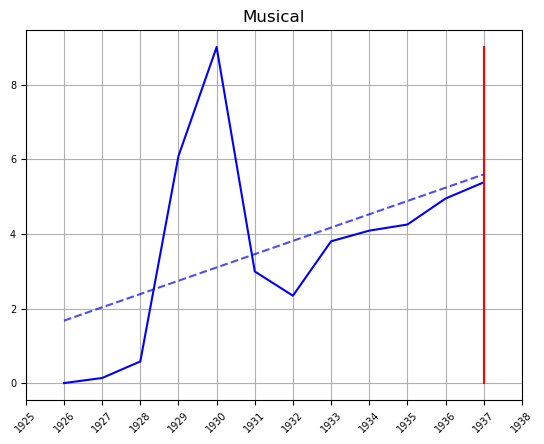

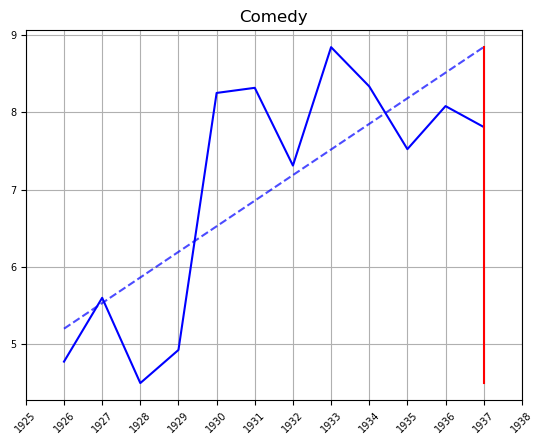

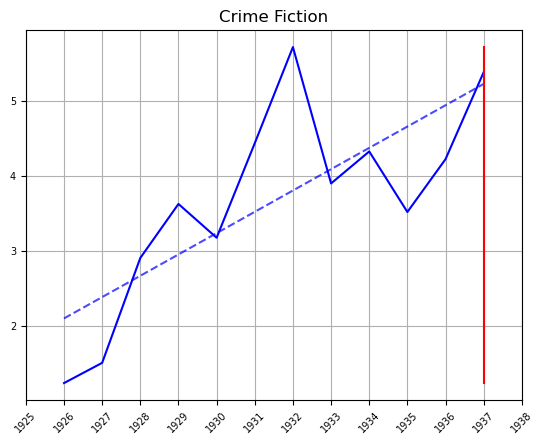

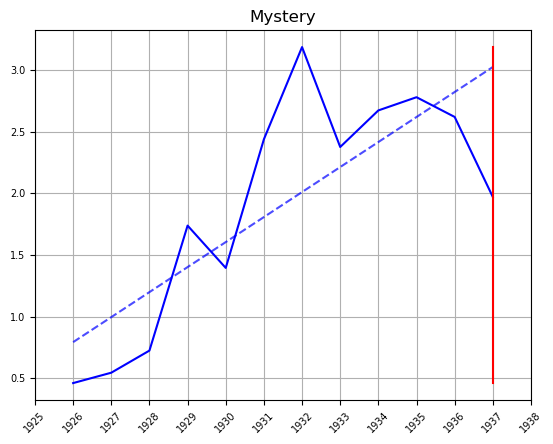

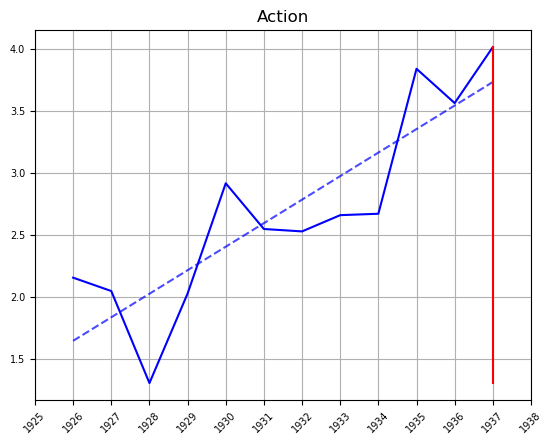

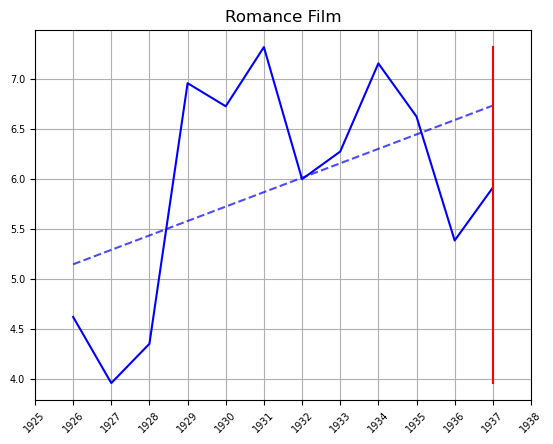

In [12]:
linear_regression_plot(movies,1925,1938,1937,'Musical')
plt.show()
linear_regression_plot(movies,1925,1938,1937,'Comedy')
plt.show()
linear_regression_plot(movies,1925,1938,1937,'Crime Fiction')
plt.show()
linear_regression_plot(movies,1925,1938,1937,'Mystery')
plt.show()
linear_regression_plot(movies,1925,1938,1937,'Action')
plt.show()
linear_regression_plot(movies,1925,1938,1937,'Romance Film')


In [13]:
genre_unique = get_all_genre(movies)

coef = []
r2 = []

for genre in genre_unique :
    coef.append(linear_regression(movies,1925,1937,genre))


In [14]:
d = {'genre': genre_unique, 'coef': coef}
df = pd.DataFrame(data=d)

In [15]:
df.sort_values(by ='coef')[-10:]

,genre,coef
285,Romance Film,0.144100
350,Western,0.160057
77,Comedy film,0.164296
5,Action/Adventure,0.175406
339,Thriller,0.184970
2,Action,0.189899
232,Mystery,0.202796
97,Crime Fiction,0.284515
74,Comedy,0.330822
229,Musical,0.356483


In [16]:
df.sort_values(by ='coef')[:10]

,genre,coef
302,Silent film,-2.590315
194,Indie,-0.934032
113,Drama,-0.090008
348,War film,-0.051981
301,Short Film,-0.033916
199,Japanese Movies,-0.023237
220,Melodrama,-0.022717
328,Surrealism,-0.022526
129,Experimental film,-0.022487
305,Slapstick,-0.021901
